# Translating Monet-Style to Photos Using Generative Adversarial Networks

## Introduction

Depending on the artist, their paintings can be quite different from a photographed image. Now with rapid advancements in Deep learning and its applications, it is now capable of translating styles from one image to the next.

The challenge for this project is to utilize Generative Adverisal Networks to translate the Monet-painting style to photos. Generative Adverisla Networks or GANs have at least two neural networks, a generator and a discriminator. The generator tries to generate fake images to trick the discriminator and the discriminator tries to distinguish the real images from the fake images.

In this specific project, we will be using Pytroch to build different types of GANs, the basic GAN, DCGAN (Deep Covulational GAN) and the Cycle GAN, to try and generate Monet-like images from real photos.

Furthur dataset description can be found in the Kaggle competition page https://www.kaggle.com/competitions/gan-getting-started/overview

### The notebook is structured as follows:
1. Setting Up Environment

   >Import modules such as pytorch and torchvision for our project. We will be using the computer's GPU for training.
   
2. Exploratory Data Analysis (EDA)
   
   >Process and visualize images. 
   
3. Data Preprocessing
   
   >Transform and normalize images to prep for training.
   
4. Basic GAN
    
   >Build model , define loss, compare images
    
5. DCGAN

   >Build model , define loss, compare images
    
7. Cycle GAN

   >Build model , define loss, compare images
   >
   >Use best hyperparameters
   >
   >Generate images from generator 
    
9. Discussion/ Summary

   >Reflect on the work, discuss results and what can be improved

10. References

    >Referenced work

## 1. Setting up the Environment

1. Load up the neccesary libraries including numpy, tensorflow and Pytorch modules.
2. Set up the working directory path
3. Set up cuda for GPU

In [137]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import random
import warnings
from PIL import Image
import pickle as pkl
import itertools

import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch import flatten
import torchvision
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchsummary import summary
from torch.autograd import Variable

In [2]:
## mount gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
torch.manual_seed(1234)

In [4]:
current_directory = os.getcwd()
##convert forward slashes to backslashes
work_dir = current_directory.replace('\\', '/')
##print("Working Base Directory:", work_dir)

## 2. Exploratory Analysis and Visualization

1. Read iage jpg and tfrec datafiles
2. Visualize photos and get shape.

In [83]:
monet_jpeg_path= work_dir + '/Documents/MS DS coursework/Intro to Deep Learning/Week 5/gan-getting-started/monet_jpg'
photo_jpeg_path= work_dir + '/Documents/MS DS coursework/Intro to Deep Learning/Week 5/gan-getting-started/photo_jpg'
monet_tfrec_path= work_dir + '/Documents/MS DS coursework/Intro to Deep Learning/Week 5/gan-getting-started/monet_tfrec/*.tfrec'
photo_tfrec_path= work_dir + '/Documents/MS DS coursework/Intro to Deep Learning/Week 5/gan-getting-started/photo_tfrec/*.tfrec'

In [93]:
def view_random_image(path, titlename, view_type= ["image","shape"]):
    listfiles = [i for i in os.listdir(path) if i.lower().endswith(('.jpg', '.jpeg'))]
    rand_img = os.path.join(path, random.choice(listfiles))
    if view_type== "image":
        img = Image.open(rand_img)
        plt.title(titlename)
        plt.imshow(img)
    else:
        imgarr = np.array(Image.open(rand_img))
        print("Image shape:", imgarr.shape)

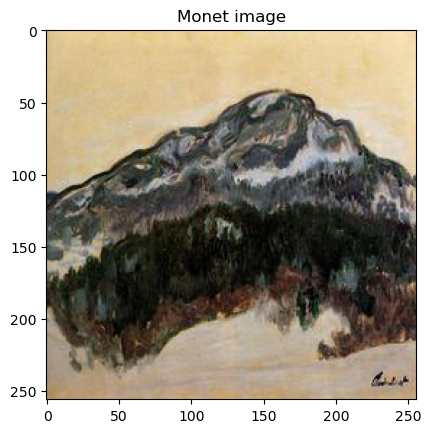

In [94]:
view_random_image(monet_jpeg_path, "Monet image", "image")

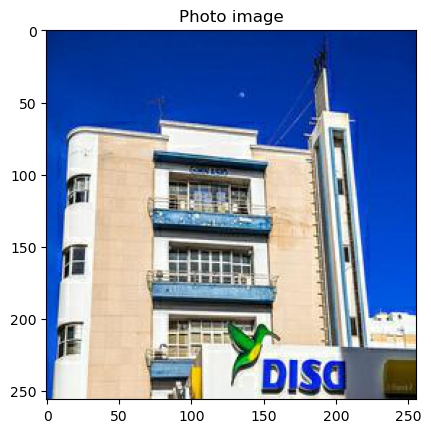

In [95]:
view_random_image(photo_jpeg_path, "Photo image", "image")

In [96]:
view_random_image(monet_jpeg_path, "Monet image", "shape")

Image shape: (256, 256, 3)


In [97]:
## Check number of jpeg monet and photo files
monjpg_imgs = len(os.listdir(monet_jpeg_path+"/"))
photjpg_imgs = len(os.listdir(photo_jpeg_path+"/"))

print("Number of monet imgs:", monjpg_imgs)
print("Number of photo imgs:", photjpg_imgs)

Number of monet imgs: 300
Number of photo imgs: 7038


In [98]:
## Extract filenames of monet_tfrec and photo_tfrec and check number files
monet_filenames = tf.io.gfile.glob(monet_tfrec_path)
photo_filenames = tf.io.gfile.glob(photo_tfrec_path)
print('Monet TFRecord Files: ', len(monet_filenames))
print('Photo TFRecord Files: ', len(photo_filenames))

Monet TFRecord Files:  5
Photo TFRecord Files:  20


In [99]:
def tfrec_features(foldpath):
    newpath= tf.io.gfile.glob(foldpath)
    dats= tf.data.TFRecordDataset(newpath)
    file= next(iter(dats.take(1)))
    ex = tf.train.Example()
    ex.ParseFromString(file.numpy())
    print('tfrec feature:', list(ex.features.feature.keys()))

In [100]:
## check the file features
tfrec_features(monet_tfrec_path)

tfrec feature: ['target', 'image_name', 'image']


In [101]:
def display_images(folder_path, num_imgs=9, row_img= 3):
    ##get imgs from folder
    imgs = os.listdir(folder_path)
    ##randomly select imgs to display
    random_images= np.random.choice(imgs, num_imgs)
    ##iterate and show images with 0 or 1 labels
    fig= plt.figure(figsize=(20, 10))
    for i, img in enumerate(random_images):
        sp= fig.add_subplot(row_img, int(num_imgs/row_img), i+1)
        # image_path = os.path.join(folder_path+'/', img)
        image_path = Image.open(folder_path+'/'+img)
        plt.imshow(image_path)

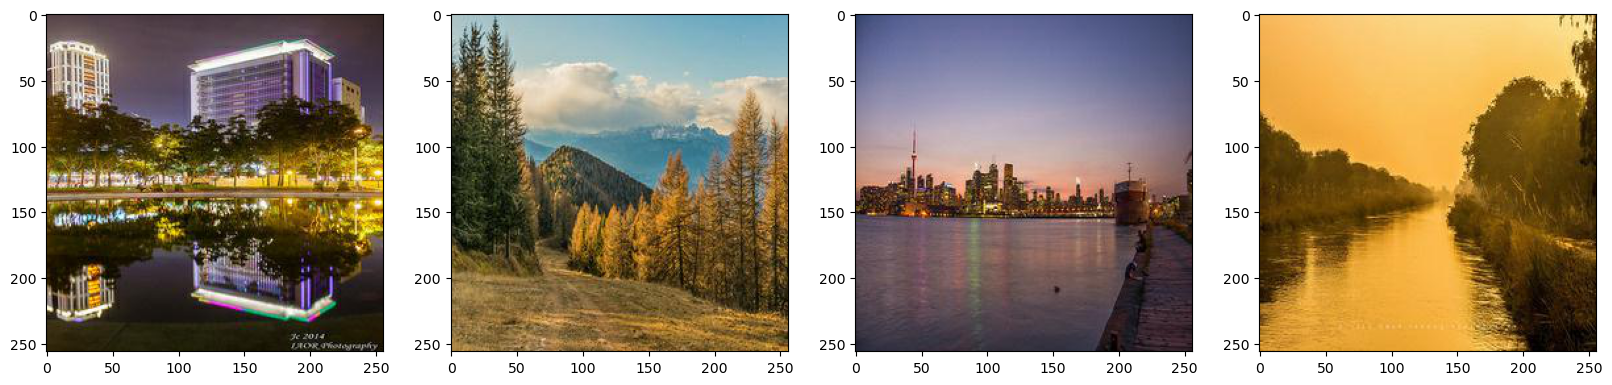

In [102]:
##Display 1x4 images randomly from the photo_jpg folder
display_images(work_dir+'/Documents/MS DS coursework/Intro to Deep Learning/Week 5/gan-getting-started/photo_jpg/', 
               num_imgs=4, row_img= 1)

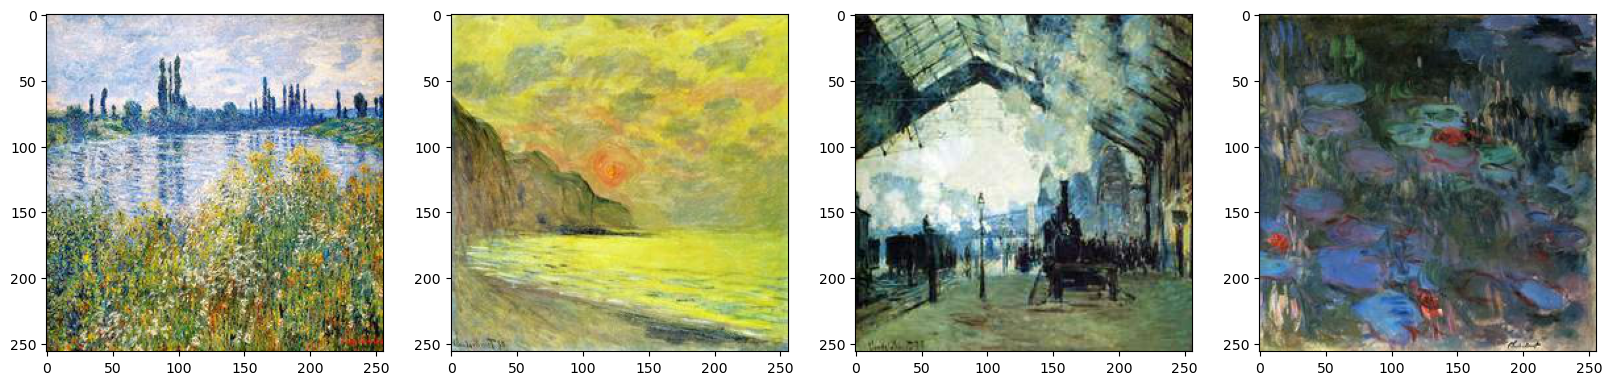

In [103]:
##Display 1x4 images randomly from the monet_jpg folder
display_images(work_dir+'/Documents/MS DS coursework/Intro to Deep Learning/Week 5/gan-getting-started/monet_jpg/', 
               num_imgs=4, row_img= 1)

## 3. Data Preprocessing

Set up data loaders for Basic GAN, DCGAN and Cycle GAN models.

1. GAN: bacthes 32, shuffled
2. DC Gan reshape to (64, 64)
2. Cycle GAN reshape to (256,256) orginal image size

In [104]:
## Image directories set
imgdir = work_dir + '/Documents/MS DS coursework/Intro to Deep Learning/Week 5/gan-getting-started/monet_jpg'
imgdir2 = work_dir + '/Documents/MS DS coursework/Intro to Deep Learning/Week 5/gan-getting-started/photo_jpg'

### Dataloader for Basic GAN

In [106]:
##Define tranformation
transform = transforms.Compose([
    transforms.ToTensor(),
    ##Norm from [-1, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

class gan_dat(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.image_list = os.listdir(root_folder)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_folder, self.image_list[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Add channel dimension
        img = image.unsqueeze(0)

        return img

##define laoddata
gan_mon = gan_dat(root_folder=imgdir, transform=transform)
gan_phot= gan_dat(root_folder=imgdir2, transform=transform)

## Define Dataloaders
# datamonets = DataLoader(gan_mon, batch_size= 32, shuffle=True, num_workers=0)
# dataphotos = DataLoader(gan_phot, batch_size= 32, shuffle=True, num_workers=0)
gan_monets = DataLoader(gan_mon, batch_size= 32, shuffle=True, num_workers=0)
gan_photos = DataLoader(gan_phot, batch_size= 32, shuffle=True, num_workers=0)

### Dataloader for DCGAN

In [159]:
class dcgan_dat(Dataset):
    def __init__(self, img_dir):
        listp = os.listdir(img_dir)
        abspath = os.path.abspath(img_dir)
        self.img_list = [os.path.join(abspath, path) for path in listp]

        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ])

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        path = self.img_list[idx]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img

dcgan_mon = dcgan_dat(imgdir)
dcgan_phot = dcgan_dat(imgdir2)
dcgan_monets = DataLoader(dcgan_mon, batch_size=16, shuffle=True, num_workers= 0)
dcgan_photos = DataLoader(dcgan_phot, batch_size=16, shuffle=False, num_workers= 0)

### Dataloader for Cycle GAN

In [219]:
class cycle_dat(Dataset):
    def __init__(self, img_dir):
        listp = os.listdir(img_dir)
        abspath = os.path.abspath(img_dir)
        self.img_list = [os.path.join(abspath, path) for path in listp]

        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ])

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        path = self.img_list[idx]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img

# Dataset
dataset_A_path = cycle_dat(imgdir)
dataset_B_path = cycle_dat(imgdir2)

batches= 1

## dataloader B not shuffled for comparion with real images
dataloader_A = DataLoader(dataset_A_path, batch_size=batches, shuffle=True, num_workers= 0, pin_memory= True)
dataloader_B = DataLoader(dataset_B_path, batch_size=batches, shuffle=True, num_workers= 0, pin_memory= True)

## 4. Basic GAN

Our first model architecure is the Generative Adverisal Network. It is made cup of two networks, a generator and a discriminator. The generator attempts to fool the discriminator with fake generated data and the discrimator tries to distinguish between real and fake.

We will implement a basic architecure with a generator and a discriminator. 

Architecture:
1. In the generator function, a randomnoise vector "z" is taken as input from latent space.
2. Fully conneted layer is used to map the noise to the intermediate size.
3. Output is flattened to 3D tensor
4. We have convolutional layers with batch normalization and ReLU activation functions appplied to upsample the tensor and increase spatial dimensions.
5. The final layer produces a 3-channel image with values in the range of -1 to 1 with the Tanh activation
6. In the discriminator function, the image tnesor is taken as an input.
7. The similar layers to the gen are used to downsample image and extract features. Final layer is sigmoid activation for real or fkae classifaction.

Initialze functions and parameters:
1. Initialize models and adversarial loss functions using binary cross entropy
1. The generator minimizes the log liklihood that the discriminator is right
2. The discriminator reduces the negative log likelihood of correctly classifying both produced and real samples.
3. Use Adam optimizer with learning rate of 2e-4 and beta aparameters at 0.5 and 0.999

Training:
1. Iterates over 40 epochs
2. Discriminator loss is calculated and optimized
3. Adversial loss is calculated and optimized
4. Show progress for every batch training
5. Display images every show_eps epoch

In [220]:
##Assign hyperparameters
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 40

In [221]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256 * 32 * 32),
            nn.ReLU(),
            nn.Unflatten(1, (256, 32, 32)),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

In [222]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64, momentum=0.82),
            nn.LeakyReLU(0.25),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.82),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.LeakyReLU(0.25),
            nn.AdaptiveAvgPool2d(1),  # Adjusted to AdaptiveAvgPool2d
            nn.Flatten(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img = self.model(img)
        return img

In [112]:
# Instantiate models and move them to the desired device
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# Sample noise as a generator input
# z = torch.randn(1, latent_dim)
# Move z to the GPU
z = torch.randn(1, latent_dim, device=device)  

##Generate a fake image
fake_image = generator(z)
print("Generated Image Shape:", fake_image.shape)

##Sample real image
real_image = torch.randn(1, 3, 256, 256, device=device)
print("Real Image Shape:", real_image.shape)

##Forward pass through the discriminator
output = discriminator(real_image)
print("Discriminator Output for Real Image:", output.item())

##Forward pass through the discriminator for the fake image
output = discriminator(fake_image)
print("Discriminator Output for Fake Image:", output.item())

Generated Image Shape: torch.Size([1, 3, 256, 256])
Real Image Shape: torch.Size([1, 3, 256, 256])
Discriminator Output for Real Image: 0.49822425842285156
Discriminator Output for Fake Image: 0.4983319938182831


In [116]:
## create function for training the images and show generated photos

def trainGAN(num_epochs, namepic, dataloader, show_eps, batches, device):
    ##traing loop
    for epoch in range(num_epochs):
        for i, batch in enumerate(dataloader):
            # Convert list to tensor
            real_images = batch[0].to(device) 
    
            # Adversarial ground truths
            valid = torch.ones(real_images.size(0), 1, device=device)
            fake = torch.zeros(real_images.size(0), 1, device=device)
    
            # Configure input
            real_images = real_images.to(device)

            #train dicriminator
            optimizer_D.zero_grad()
    
            # Sample noise as generator input
            z = torch.randn(real_images.size(0), latent_dim, device=device)
    
            # Generate a batch of images
            fake_images = generator(z)
    
            ## Measure discriminator's ability o classify real and fake images
            real_loss = adversarial_loss(discriminator(real_images), valid)
            fake_loss = adversarial_loss(discriminator(fake_images), fake)
            d_loss = (real_loss + fake_loss) / 2
    
            # Backward pass and optimize
            d_loss.backward()
            optimizer_D.step()

            #train generator
            optimizer_G.zero_grad()
    
            # Generate a batch of images
            gen_images = generator(z)
    
            # Adversarial loss
            g_loss = adversarial_loss(discriminator(gen_images), valid)
    
            # Backward pass and optimize
            g_loss.backward()
            optimizer_G.step()

            ##display and monitor progress
            if (i + 1) % batches == 0:
                if (epoch + 1) % show_eps == 0:
                    print(
                        f"Epoch [{epoch+1}/{num_epochs}] Batch {i+1}/{len(dataloader)} "
                        f"Discriminator Loss: {d_loss.item():.4f} Generator Loss: {g_loss.item():.4f}"
                    )
                    
        ## Save generated images for every epoch
        if (epoch + 1) % show_eps == 0:
            with torch.no_grad():
                z = torch.randn(4, latent_dim, device=device)
                generated = generator(z).detach().cpu()
                print("generated "+namepic+ " at epoch "+ str(epoch+1))
                grid = torchvision.utils.make_grid(generated, nrow=4, normalize=True)
                plt.imshow(np.transpose(grid, (1, 2, 0)))
                plt.axis("off")
                plt.show()

Epoch [10/40] Batch 10/10 Discriminator Loss: 0.6581 Generator Loss: 0.7427
generated monets at epoch 10


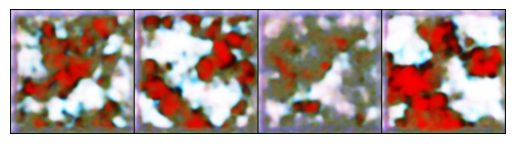

Epoch [20/40] Batch 10/10 Discriminator Loss: 0.5871 Generator Loss: 0.7688
generated monets at epoch 20


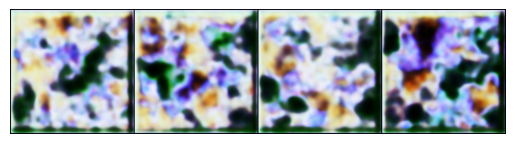

Epoch [30/40] Batch 10/10 Discriminator Loss: 0.6888 Generator Loss: 0.7545
generated monets at epoch 30


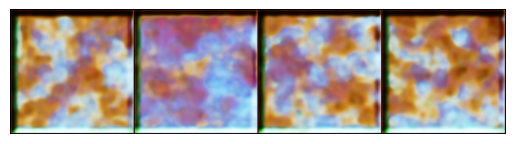

Epoch [40/40] Batch 10/10 Discriminator Loss: 0.6936 Generator Loss: 0.7744
generated monets at epoch 40


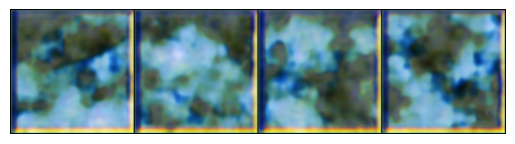

In [117]:
trainGAN(num_epochs= num_epochs, namepic= "monets", dataloader= gan_monets, show_eps=10, batches= 10, device= device)

Epoch [10/40] Batch 220/220 Discriminator Loss: 0.3267 Generator Loss: 1.9370
generated photos at epoch 10


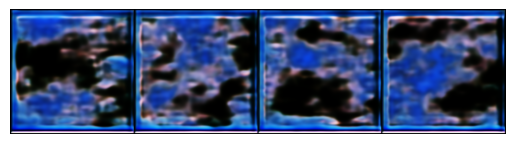

Epoch [20/40] Batch 220/220 Discriminator Loss: 0.0216 Generator Loss: 3.5321
generated photos at epoch 20


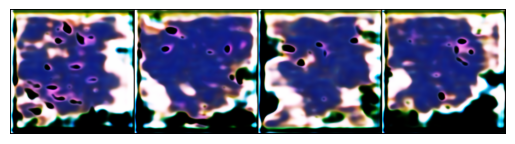

Epoch [30/40] Batch 220/220 Discriminator Loss: 0.1864 Generator Loss: 3.4600
generated photos at epoch 30


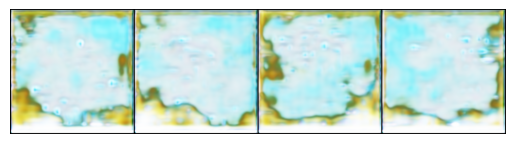

Epoch [40/40] Batch 220/220 Discriminator Loss: 0.0142 Generator Loss: 3.2617
generated photos at epoch 40


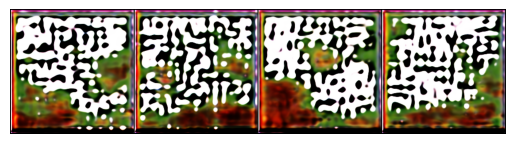

In [118]:
ltrainGAN(num_epochs= num_epochs, namepic= "photos", dataloader= gan_photos, show_eps=10, batches= 220, device= device)

What a work of art! In seriousness, it, looks like a case of vanishing/exploding gradients and instability in the model. We probably need a more sutiable architecture for our goal of image to image translation. Let's move on to DCGANs to see if we can generate actual images.

## 5. DCGAN

Our second model architecure is the Deep Convolutional Generative Adverisal Network or DCGAN. IT is designed to improve the stability and effectiveness or training GANS for iage synthesis through use of convolutional layers.

Architecture:
1. In the generator function, a randomnoise vector x of z_size is taken as input
2. Convolutional layers to upsample the input noise
3. We have 4 sets for convolutional tranpsose layers with activation ReLu and Batch Nromalization
4. Output channel of 3 for RBG, Activation Tanh for pixels to be in range -1 to 1
5. Seimilar sets of Convultional layers with activation sigmoid for probability out

Initialze functions and parameters:
1. Initialize models loss functions using binary cross entropy
2. Intial noise function for uniform distburtion of -1 to 1
3. Use Adam optimizer with learning rate of 2e-4 and beta aparameters at 0.5 and 0.999

Training:
1. Iterates over 100 epochs with batch size 16
2. Discriminator loss is calculated and optimized via backwards pass
3. Show progress for every batch training
4. Display images every show_eps epoch
5. Save image pickle file and return sample values and losses

In [146]:
##hyperparameters setting
epochs = 300
batch_size = 16
z_size = 128
samp_size = 16
conv_dim = 64
lr = 0.0001
beta_1=0.5
beta_2=0.999

In [147]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=64):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_size, conv_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(conv_dim * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(conv_dim * 8, conv_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(conv_dim * 4, conv_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(conv_dim * 2, conv_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(conv_dim, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1) 
        return self.main(x)

In [148]:
## Show gen parameters
gen = Generator(128).cuda()
summary(gen, (128, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       1,048,576
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [149]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, conv_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
   
            nn.Conv2d(conv_dim, conv_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(conv_dim * 2, conv_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(conv_dim * 4, conv_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
          
            nn.Conv2d(conv_dim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )


    def forward(self, x):
        return self.main(x)

In [150]:
## Show disc parameters
disc = Discriminator(32).cuda()
summary(disc, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           1,536
         LeakyReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 16, 16]          32,768
       BatchNorm2d-4           [-1, 64, 16, 16]             128
         LeakyReLU-5           [-1, 64, 16, 16]               0
            Conv2d-6            [-1, 128, 8, 8]         131,072
       BatchNorm2d-7            [-1, 128, 8, 8]             256
         LeakyReLU-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 4, 4]         524,288
      BatchNorm2d-10            [-1, 256, 4, 4]             512
        LeakyReLU-11            [-1, 256, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           4,096
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 694,656
Trainable params:

In [151]:
class dcgan:
    def __init__(self, z_size, conv_dim):
        self.z_size = z_size

        self.D = Discriminator(conv_dim)
        self.G = Generator(z_size, conv_dim)

        self.device = torch.device("cuda")
        
        self.D.to(self.device)
        self.G.to(self.device)

    ##save the model
    def save_model(self, path):
        torch.save({'D_state_dict': self.D.state_dict(),
                    'G_state_dict': self.G.state_dict()}, 
                   path)
    ##load the model
    def load_model(self, path):
        checkpoint = torch.load(path, map_location=self.device)
        self.D.load_state_dict(checkpoint['D_state_dict'])
        self.G.load_state_dict(checkpoint['G_state_dict'])

    ##calculate the loss
    def calc_loss(self, output, labs):
        criterion = nn.BCELoss()
        cl= criterion(output.squeeze(), labs)
        return cl

    ##calculate real loss
    def real_loss(self, d_out):
        batch_size = d_out.size(0)
        labs = torch.ones(batch_size).to(self.device)*0.8
        return self.calc_loss(d_out, labs) 

    ##calculate fake loss
    def fake_loss(self, d_out):
        batch_size = d_out.size(0)
        labs = torch.ones(batch_size).to(self.device)*0.1
        return self.calc_loss(d_out, labs)

    ##calculate the noise
    def noise(self, size):
        z = np.random.uniform(-1, 1, size=size)
        noise= torch.from_numpy(z).float().to(self.device)
        return noise

    ##define the training generator function
    def train_gen(self, g_opti, size):
        g_opti.zero_grad()
        z = self.noise(size)
        fake_img = self.G(z)
        d_fake = self.D(fake_img)
        g_loss = self.real_loss(d_fake)
        g_loss.backward()
        g_opti.step()
        gloss= g_loss.item()
        return gloss

    ##define the training discriminator function
    def train_dis(self, d_opti, real_img, size):
        d_opti.zero_grad()
        d_real = self.D(real_img.to(self.device)).view(-1)
        d_real_loss = self.real_loss(d_real)
        z = self.noise(size)
        fake_img = self.G(z)
        d_fake = self.D(fake_img)
        d_fake_loss = self.fake_loss(d_fake)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_opti.step()
        dloss= d_loss.item()
        return dloss

    ##function for training the model
    def train(self, num_epochs, show_eps, d_opti, g_opti, dataloader, z_size, sample_size):
        ##initiate start time fir training
        start_time = time.time()
        samples = []
        losses = []
        z = self.noise((sample_size, z_size))
        self.D.train()
        self.G.train()
        ##device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f'Training model on {self.device}')

        ##iterate and show training dis and gen loss
        for epoch in range(num_epochs):
            for i, real_imgs in enumerate(dataloader):                    
                batch_size = real_imgs.size(0)
                d_loss = self.train_dis(d_opti, real_imgs, (sample_size, z_size))
                g_loss = self.train_gen(g_opti, (sample_size, z_size))

           # Print every "show_eps" number of epochs
            if (epoch + 1) % show_eps == 0:
                total_elapsed_time = time.time() - start_time
                print('epoch: {:3d}/{:3d} --- d_loss {:6.4f} --- g_loss {:6.4f} --- total elapsed time: {:.2f} seconds'.format(
                    epoch + 1, num_epochs, d_loss, g_loss, total_elapsed_time))

            ##append losses to list from training
            losses.append((d_loss, g_loss))
            self.G.eval()
            samples.append(self.G(z))
            self.G.train()

        ##load dataset pickle
        with open('dcgan_output.pkl', 'wb') as file:
            pkl.dump(samples, file)

        ##return sample images and losses
        return samples, losses 

In [152]:
##get mod
dcgan_mod = dcgan(z_size, conv_dim)

##optimizer
d_opti = optim.Adam(dcgan_mod.D.parameters(), lr, betas=[beta_1, beta_2])
g_opti = optim.Adam(dcgan_mod.G.parameters(), lr, betas=[beta_1, beta_2])

# train
res, loss_hist = dcgan_mod.train(epochs, 
                                 30,
                                 d_opti, 
                                 g_opti, 
                                 dcgan_monets, 
                                 z_size, 
                                 samp_size)

Training model on cuda
epoch:  30/300 --- d_loss 1.1005 --- g_loss 1.3753 --- total elapsed time: 43.39 seconds
epoch:  60/300 --- d_loss 0.9393 --- g_loss 1.6661 --- total elapsed time: 81.79 seconds
epoch:  90/300 --- d_loss 0.8895 --- g_loss 1.5184 --- total elapsed time: 110.96 seconds
epoch: 120/300 --- d_loss 0.8660 --- g_loss 1.6265 --- total elapsed time: 142.48 seconds
epoch: 150/300 --- d_loss 0.8525 --- g_loss 1.6423 --- total elapsed time: 175.97 seconds
epoch: 180/300 --- d_loss 0.8664 --- g_loss 1.4919 --- total elapsed time: 209.22 seconds
epoch: 210/300 --- d_loss 0.8660 --- g_loss 2.3406 --- total elapsed time: 307.97 seconds
epoch: 240/300 --- d_loss 0.8427 --- g_loss 1.9297 --- total elapsed time: 437.39 seconds
epoch: 270/300 --- d_loss 0.8464 --- g_loss 1.8055 --- total elapsed time: 575.57 seconds
epoch: 300/300 --- d_loss 0.8369 --- g_loss 1.5889 --- total elapsed time: 697.27 seconds


In [153]:
def show_imgs(sample_res, epochs):
    fig, axes = plt.subplots(figsize=(12, 6), nrows=2, ncols=4, sharey=True, sharex=True)

    # Iterate through the axes and sample images
    for ax, img in zip(axes.flatten(), sample_res[epochs - 1]):
        ##Convert the PyTorch tensor to a NumPy array
        img = img.detach().cpu().numpy()
        ##Transpose the dimensions to match matplotlib
        img = np.transpose(img, (1, 2, 0))
        ##Rescale the pixel values to [0, 255]
        img = ((img + 1) * 255 / 2).astype(np.uint8)
        ##Display the image using imshow
        im= ax.imshow(img)

    plt.show()

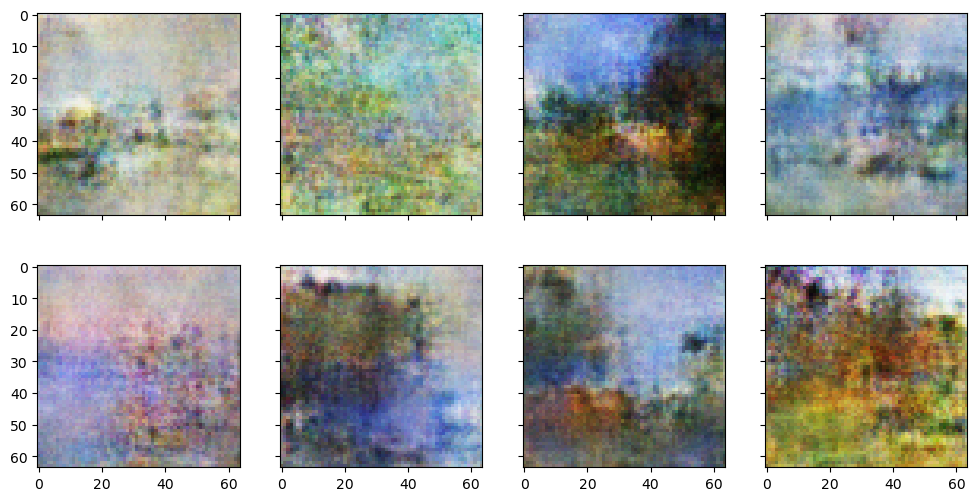

In [154]:
show_imgs(res, epochs)

In [155]:
dcgan_mod = dcgan(z_size, conv_dim)
##Save the model
dcgan_mod.save_model('saved_gan_model.pth')

In [156]:
## Now generate monets from photo images
## load the model
dcgan_mod.load_model('saved_gan_model.pth')

In [160]:
##photo epochs
phot_epochs= 20

##optimizer
d_opti = optim.Adam(dcgan_mod.D.parameters(), lr, betas=[beta_1, beta_2])
g_opti = optim.Adam(dcgan_mod.G.parameters(), lr, betas=[beta_1, beta_2])

##train
res, loss_hist = dcgan_mod.train(phot_epochs, 
                                 10,
                                   d_opti, 
                                   g_opti, 
                                   dcgan_photos, 
                                   z_size, 
                                   samp_size)

Training model on cuda
epoch:  10/ 20 --- d_loss 1.1446 --- g_loss 1.5835 --- total elapsed time: 272.24 seconds
epoch:  20/ 20 --- d_loss 0.9422 --- g_loss 1.7644 --- total elapsed time: 494.24 seconds


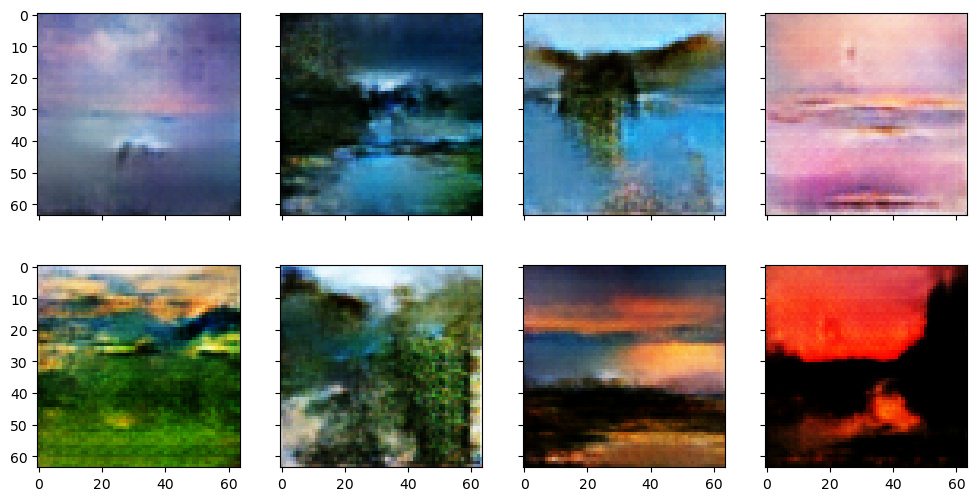

In [161]:
show_imgs(res, phot_epochs)

After generating the images from the trained model, we can see Monet style transfered to the real images. However it could be that the photos are just blurry. The blurriness can be caused by not enough training, too narrow of a noise sampling distribution or not effectively using normalizations. 

Let's process to our final model, the Cycle GAN, to see if we can do better with our image generation outputs for monet-esque style.

## 6. Cycle GAN

Our final model architecure is the Cycle GAN. It was introduced to translate images from one domain to another that do not require paired examples for training. It's most prominent feature is the ability to learn mappings between two domains such as paintings and photos in both directions without need for aligning training data. It consists of two generators and two discriminators. It is designed to learn mappings that are consistent in both directions.

Architecture:
1. In the generator function, we utilize in sequence, the encoder block, residual block and decoder blocks.
2. Encoder that takes input of 3 channels and reduces its spatial dims using conv layers, batch norm and leaky relu activation
3. Relu activation helps to prevent vanishing gradient problem
4. Residual blocks used to refine features consisting of two conv layers, instance norm and leaky relu
5. Instance normalization helps normalizes batches independently.
6. Decoder blocks refines feaures back to the orginal image dims using transpose conv layers and instance norma and leaky relu.
7. Final layer is Tanh
8. Apply forward pass for all three blocks
9. In the dicriminator function, we use similar layers and get a probability of real or fake in last single channel output.
10. Thn apply forward pass for disc model

Initialze functions and parameters:
1. Initialize models loss functions using binary cross entropy
2. Intial noise function for uniform distburtion of -1 to 1
3. Use Adam optimizer with learning rate of 2e-4 and beta aparameters at 0.5 and 0.999
4. Note that best hyperparameters are chosen above after testing with removal/addition of layers, different learning rates, etc.

Training:
1. Iterates over 10 slow epochs
2. Losses is calculated and optimized via backwards pass
3. Show progress for every batch training
5. Generate images from the trained generator and save them in folder
6. Display the images

In [223]:
## View dataloader info
dataloader_B

In [224]:
len(dataloader_B)

7038

In [225]:
## Define generator class

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Conv2d(3, 64, 4, 2, 1, bias=True),
            # nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # nn.InstanceNorm2d(64),
            
            # nn.Conv2d(64, 128, 4, 2, 1, bias=True),
            # nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # nn.InstanceNorm2d(128),
                
            # nn.Conv2d(128, 256, 4, 2, 1, bias=True),
            # nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # nn.InstanceNorm2d(256),
        )

        # Residual blocks
        self.res_blocks = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(128),

            # ResidualBlock(256),
            # ResidualBlock(256),
        )

        # Decoder
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, output_padding=1),
            # nn.InstanceNorm2d(128),
            # nn.Dropout(0.5),
            # nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x+ self.res_blocks(x)
        x = self.decoder(x)
        return x

In [226]:
## Define discriminator class

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            # nn.InstanceNorm2d(256),
            # nn.LeakyReLU(0.2, inplace=True),

            # nn.Conv2d(256, 1, kernel_size=4, stride=2, padding=1)
            nn.Conv2d(128, 1, kernel_size=4, stride=2, padding=1)
        )

    def forward(self, x):
        return self.model(x)


In [227]:
##Initialize models
G_AB = Generator().to(device)
G_BA = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

##Loss functions
criterion_GAN = nn.MSELoss().to(device)
criterion_cycle = nn.L1Loss().to(device)

##Optimizers
opti_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))
opti_DA = torch.optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
opti_DB = torch.optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [228]:
opti_G

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)

In [229]:
opti_DA

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)

In [230]:
## Cycle GAN function as adapted from the tutorials listed in below references section

def train_cycle_gan(num_epochs, 
                    ##photo_epoch,
                    num_samples,
                    dataloader_A, 
                    dataloader_B, 
                    output_folder,
                    G_AB, 
                    G_BA, 
                    D_A, 
                    D_B, 
                    criterion_GAN, 
                    criterion_cycle, 
                    optimizer_G,
                    optimizer_D_A, 
                    optimizer_D_B, 
                    device):
    
    for epoch in range(1, 1+num_epochs):
        start_time = time.time()
        for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):
            ##Assuming real_A and real_B are batches of images from domains A and B
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            # Adversarial ground truths
            # valid = torch.ones((real_A.size(0), 1, 32, 32)).to(device)
            # fake = torch.zeros((real_A.size(0), 1, 32, 32)).to(device)

            valid = torch.ones((real_A.size(0), 1, 1, 1)).to(device)
            fake = torch.zeros((real_A.size(0), 1, 1, 1)).to(device)

            # ------------------
            # Train Generators
            # ------------------

            ##optimizer_G.zero_grad()

            # Identity loss
            loss_identity_A = criterion_cycle(G_BA(real_A), real_A)
            loss_identity_B = criterion_cycle(G_AB(real_B), real_B)

            # GAN loss for domain A to domain B
            fake_B = G_AB(real_A)
            loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)

            # Cycle loss
            recovered_A = G_BA(fake_B)
            loss_cycle_A = criterion_cycle(recovered_A, real_A)

            # GAN loss for domain B to domain A
            fake_A = G_BA(real_B)
            loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

            # Cycle loss
            recovered_B = G_AB(fake_A)
            loss_cycle_B = criterion_cycle(recovered_B, real_B)

            # Total loss
            loss_G = (
                loss_identity_A + loss_identity_B +
                2.0 * loss_GAN_AB + 2.0 * loss_GAN_BA + 10.0 * loss_cycle_A + 10.0 * loss_cycle_B
            )
            
            # Update generators
            optimizer_G.zero_grad()
            loss_G.backward()
            optimizer_G.step()

            # ----------------------
            # Train Discriminator A
            # ----------------------

            optimizer_D_A.zero_grad()

            # Real loss
            loss_real_A = criterion_GAN(D_A(real_A), valid)
            
            # Fake loss
            fake_A = G_BA(real_A.detach())
            loss_fake_A = criterion_GAN(D_A(fake_A), fake)

            # Total loss
            loss_D_A = 0.5 * (loss_real_A + loss_fake_A)

            loss_D_A.backward()
            optimizer_D_A.step()

            # ----------------------
            # Train Discriminator B
            # ----------------------

            optimizer_D_B.zero_grad()

            # Real loss
            loss_real_B = criterion_GAN(D_B(real_B), valid)

            # Fake loss
            fake_B = G_AB(real_B.detach())
            loss_fake_B = criterion_GAN(D_B(fake_B), fake)

            # Total loss
            loss_D_B = 0.5 * (loss_real_B + loss_fake_B)

            loss_D_B.backward()
            optimizer_D_B.step()

        ##Display loss results every 5 epochs and print training information
        if epoch % 5 == 0:    
            elapsed_time = time.time() - start_time
            print(f"Epoch [{epoch}/{num_epochs}], "
                  f"Time: {elapsed_time:.2f}s, "
                  f"Gen Loss: {loss_G.item():.4f}, "
                  f"Disc Loss A: {loss_D_A.item():.4f}, "
                  f"Disc Loss B: {loss_D_B.item():.4f}")

        # if epoch == num_epochs:
        #     # Save generated images after each epoch
        #     save_generated_images(G_AB, dataloader_B, output_folder, epoch, num_samples)

In [231]:
##Train the CycleGAN
num_epochs = 20
##num_samples= len(dataloader_B)
##number of samples code is for images
num_samples= 15

train_cycle_gan(num_epochs, 
                num_samples,
                dataloader_A, 
                dataloader_B, 
                output_folder,
                G_AB, G_BA, D_A, D_B, 
                criterion_GAN, 
                criterion_cycle, 
                opti_G, 
                opti_DA, 
                opti_DB,
                device)

Epoch [5/20], Time: 16.73s, Gen Loss: 5.0880, Disc Loss A: 0.0460, Disc Loss B: 0.1067
Epoch [10/20], Time: 19.24s, Gen Loss: 6.8281, Disc Loss A: 0.0324, Disc Loss B: 0.1512
Epoch [15/20], Time: 18.46s, Gen Loss: 4.9411, Disc Loss A: 0.0475, Disc Loss B: 0.0636
Epoch [20/20], Time: 15.96s, Gen Loss: 6.4881, Disc Loss A: 0.0260, Disc Loss B: 0.2359


In [232]:
def save_generated_images(generator, dataloader, output_folder, epoch, num_samples=20):
    generator.eval()
    
    ##Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            real_images = data if isinstance(data, torch.Tensor) else data[0]

            ##stop if i matches number of sample images
            if i == num_samples:
                break
            
            ##Generate fake images
            fake_images = generator(real_images.to(device))
            
            ##Save the generated images
            for j in range(len(fake_images)):
                image_path= os.path.join(output_folder, f"generated_image_epoch_{epoch}_sample_{i}.png")
                save_image(fake_images[j], image_path)

In [233]:
class cycle_dat2(Dataset):
    def __init__(self, img_dir):
        listp = os.listdir(img_dir)
        abspath = os.path.abspath(img_dir)
        self.img_list = [os.path.join(abspath, path) for path in listp]

        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ])

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        path = self.img_list[idx]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img

# Dataset
dataset_A_path2 = cycle_dat2(imgdir)
dataset_B_path2 = cycle_dat2(imgdir2)

batchgen= 1

## dataloader B not shuffled for comparion with real images
dat_mon = DataLoader(dataset_A_path2, batch_size=batchgen, shuffle=True, num_workers= 0, pin_memory= True)
dat_img = DataLoader(dataset_B_path2, batch_size=batchgen, shuffle=False, num_workers= 0, pin_memory= True)

In [234]:
##Generate images for photos 
output_folder= "phot_mon_images"
save_generated_images(G_AB, dat_img, output_folder, num_epochs, num_samples= 20)

In [235]:
# output_folder= "phot_images"
# save_generated_images(G_BA, dat_img, output_folder, num_epochs, num_samples= 20)

In [236]:
##Create function for displauing the images

def display_images(dataset, output_folder, epoch, batches=24, num_samples=8):
    ##load the orginal images in the same order
    dataloader = DataLoader(dataset, batch_size=batches, shuffle=False)
    real_images = next(iter(dataloader))

    ##save loaded images in a list
    generated_images = []

    for i in range(num_samples):
        image_path = os.path.join(output_folder, f"generated_image_epoch_{epoch}_sample_{i}.png")
        generated_image = Image.open(image_path)
        generated_images.append(generated_image)

    ##display images in 2 rows, 8 columns of real and generated photos
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))

    for i in range(num_samples):
        axes[0, i].imshow(np.transpose(real_images[i].numpy(), (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Real {i+1}')

        axes[1, i].imshow(np.array(generated_images[i]))
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Monet Gen {i+1}')

    plt.show()


In [237]:
# dataset = DataLoader(dataset_B_path, batch_size=1, shuffle=False, num_workers= 0)
dataset = dataset_B_path2

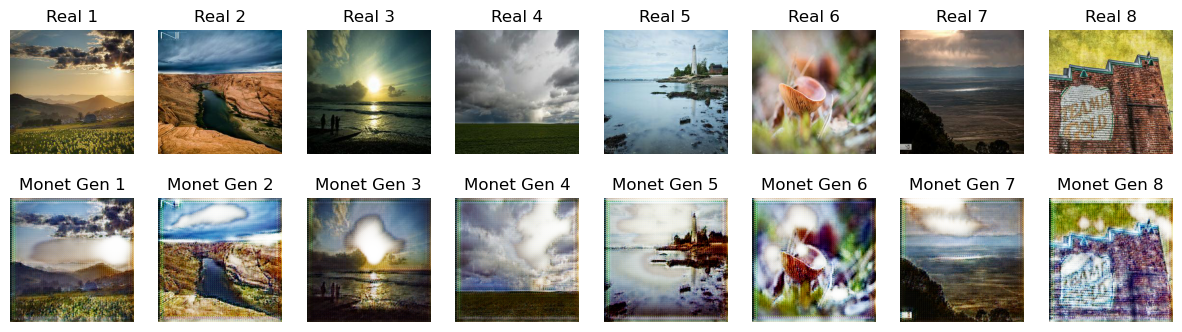

In [238]:
##Display the images in grid
display_images(dataset, output_folder, epoch=20)

We can see from the generated images that they are starting to take the visual style of the monet paintings with the meshing colors. However, the images produces large white areas. This indicates possible vanishing gradient issues, mode collapse, or certain neurons having too high or low values (can be mitigated using dropouts or batch normalization layers). Thus, we can see that our current generated images from the real photos are still pretty far from being very monet-like. We will stop here for now and retrieve submission score.

In [ ]:
##Zip generated images
# shutil.make_archive(output_folder, 'zip', output_folder)

## 7. Discussion/ Summary

In this project workflow, we began with loading up the jpg and tfrec images and viewing how they looked like. We checked the shape of the image what our input shape needs to be so we can transform the images accordingly.

Using Pytorch, we proceeded with building out and training different model architectures, each with increasing complexity and the ability to generate better monet-like photos: 

1. Basic GAN (Basic GAN)
2. DCGAN (Deep Convolutional GAN)
3. Cycle GAN

There were many hyperparaters tested using the Cycle GAN model architecture such as the number of neurons, layers, residual layers, upsampling and downsampling layers, but ultimately we decided to go with a more simple process so that we can open it to more improvements from there.

With deeper architecures, appropriate layers and optimized hyperparameters, we can definitely generate photos that are more monet-like.


## 8. References

1. https://www.geeksforgeeks.org/generative-adversarial-network-gan/
2. https://www.kaggle.com/code/vyacheslavshen/dcgan-pytorch-tutorial
3. https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
4. https://www.tensorflow.org/tutorials/generative/cyclegan
5. https://www.tongzhouwang.info/better_cycles/report.pdf
6. https://www.kaggle.com/code/nachiket273/cyclegan-pytorch/notebook